In [1]:
# %cd ".." - install dreye with pip install -e .

In [1]:
from dreye.estimators.dependent_excitation_models import DependentExcitationFit

In [2]:
import dreye
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [3]:
mspectra = dreye.create_measured_spectra_container(
    [340, 360, 400, 450, 505, 565, 620]
)
mspectra = dreye.create_measured_spectra_container(
    [340,  450, 565]
)

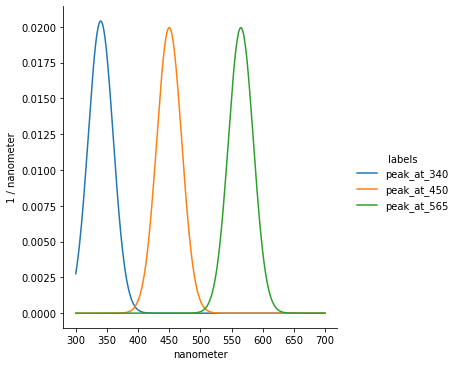

In [4]:
mspectra.normalized_spectra.plot()

In [5]:
mspectra.intensity_bounds

(array([0., 0., 0.]), array([100., 100., 100.]))

In [6]:
pr_model = dreye.create_photoreceptor_model(
    [360, 380, 430, 480, 550]
)
pr_model = dreye.create_photoreceptor_model(
    [360, 430, 550], 
    photoreceptor_type='log', 
    capture_noise_level=1e-4
)

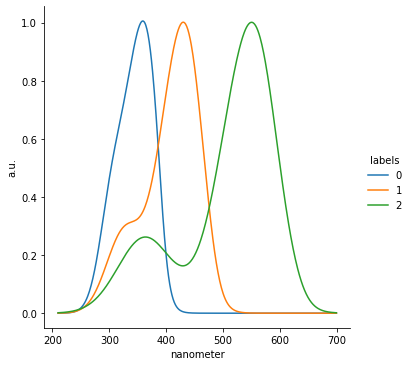

In [7]:
pr_model.sensitivity.plot()

In [8]:
# seed
rng = default_rng(14)

In [9]:
# model with all LEDs available in each subframe

In [20]:
layer_assignments = [
    [0, 2], [0, 1], [1, 2], [0, 1], [1, 2], [0, 1], [0, 2]
]

In [21]:
resolution = (16, 16)
n_subframes = len(layer_assignments)
bit_depth = 5
n_pixels = resolution[0] * resolution[1]

# random weights for leds
led_weights = rng.random(
    (len(mspectra), n_subframes)
) * 40
led_weights = np.zeros(
    (len(mspectra), n_subframes)
)
for idx, idcs in enumerate(layer_assignments):
    led_weights[idcs, idx] = rng.random(len(idcs)) * 40


# normalized capture matrix
A = pr_model.capture(
    mspectra.normalized_spectra, 
    return_units=False
)

pixel_strength = rng.random((n_pixels, n_subframes))
pixel_strength = pixel_strength / np.max(pixel_strength)
pixel_strength = (np.ceil(pixel_strength * 2**bit_depth) - 1) / (2**bit_depth - 1)

X = (pixel_strength @ led_weights.T) @ A
X = pr_model.excitefunc(X)

In [22]:
led_weights

array([[26.62349114, 34.60049651,  0.        , 25.14051552,  0.        ,
         7.55346443, 26.87266565],
       [ 0.        , 32.22289194, 28.5973976 , 19.62487827,  0.90849547,
        37.44587638,  0.        ],
       [26.42077031,  0.        ,  1.33082245,  0.        , 10.2826321 ,
         0.        , 37.36772359]])

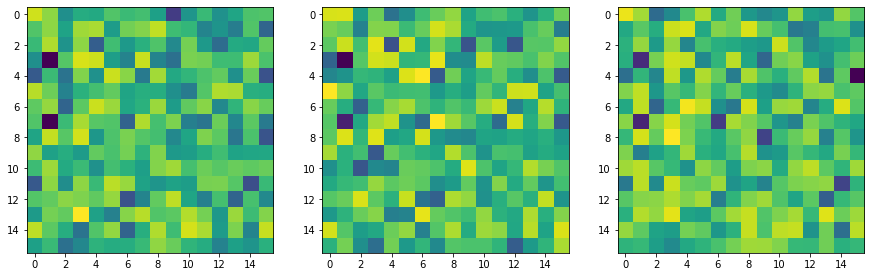

In [23]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(5 * X.shape[1], 5))
for idx, ix in enumerate(X.T):
    axes[idx].imshow(ix.reshape(resolution))

In [24]:
model = DependentExcitationFit(
    photoreceptor_model=pr_model,
    n_epochs=5,
    measured_spectra=mspectra,
    seed=11, 
    independent_layers=n_subframes, 
    bit_depth=bit_depth, 
    epoch_iter=10, 
    n_jobs=10,
    verbose=True, 
    layer_assignments=layer_assignments, 
    exploit=0.3, 
    n_exploit=5, 
    round_during_training=False, 
    normalize_during_training=False,
    sim=False
#     ignore_bounds=True
)

In [25]:
import time

In [26]:
before = time.time()
model.fit(X)
after = time.time()

epochs: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 2.4791e-01, final cost 2.3625e-01, first-order optimality 3.14e-04.


In [27]:
model.score()

0.9931869792867077

In [20]:
model.residuals()

array([[ 5.01418365,  2.06637499,  2.22767749],
       [ 6.95191326, -0.67913675,  1.39734494],
       [ 3.33062595, -2.60175901, -2.68561992],
       [ 4.83197564, -2.69728621,  0.94509601],
       [ 6.16772905, -3.75415522, -1.14668948],
       [ 6.5375401 ,  1.54109096,  2.03477707],
       [ 1.10078554, -0.52816983,  1.30663874],
       [ 7.7690058 ,  1.9536241 ,  1.35098356],
       [ 5.81036802, -2.94368827, -2.30488791],
       [-4.0438029 , -0.04638125, -3.31182689],
       [-0.01720861,  0.02964777, -2.0806434 ],
       [ 3.08297851,  0.64394617,  1.50810804],
       [ 5.37861522,  0.27141558,  1.53620665],
       [-7.27335778,  0.03113102, -1.75385407],
       [-5.84507248, -0.49575531, -2.11027275],
       [ 2.93351671,  1.46794775, -0.69594557]])

In [32]:
X

array([[ 8.84766607, 10.56038399, 13.56852421],
       [ 4.24694645,  8.08903724, 12.4758997 ],
       [ 8.63549039,  9.65798906, 13.90694789],
       [ 4.90277084,  6.27852279,  9.01298378]])

In [18]:
np.round(model.excite_X_, 2)

array([[ 2.31,  3.43,  8.93],
       [ 3.31,  3.78, 10.95],
       [ 3.69,  3.82, 12.13],
       [ 4.55,  5.2 , 14.74],
       [ 4.23,  3.18,  9.44],
       [ 5.09,  4.6 , 14.2 ],
       [ 4.47,  7.32, 17.59],
       [ 3.39,  6.02, 14.41],
       [ 0.66,  3.38,  6.36],
       [ 2.59,  4.03,  8.99],
       [ 1.05,  5.45,  9.69],
       [ 1.54,  2.9 ,  6.35],
       [ 4.06,  5.1 , 11.73],
       [ 5.32,  5.76, 16.71],
       [ 2.91,  4.75, 11.95],
       [ 2.27,  3.66, 10.02],
       [ 4.23,  5.89, 14.11],
       [ 2.55,  5.1 , 12.09],
       [ 2.21,  6.59, 13.24],
       [ 2.84,  3.8 , 10.63],
       [ 1.76,  2.18,  5.61],
       [ 3.15,  4.4 , 10.25],
       [ 1.5 ,  2.01,  5.83],
       [ 2.55,  5.56, 12.61],
       [ 2.95,  2.51,  6.72],
       [ 4.85,  8.18, 19.35],
       [ 4.83,  4.92, 14.7 ],
       [ 2.41,  5.65, 13.01],
       [ 2.79,  6.71, 14.5 ],
       [ 2.78,  6.7 , 15.83],
       [ 0.93,  3.89,  7.19],
       [ 4.13,  5.29, 12.43],
       [ 3.85,  4.76, 11.82],
       [ 4

In [19]:
np.round(model.fitted_excite_X_, 2)

array([[ 2.1 ,  3.15,  8.32],
       [ 3.14,  3.48, 10.24],
       [ 3.47,  3.48, 11.27],
       [ 4.44,  5.13, 14.5 ],
       [ 3.85,  2.79,  8.7 ],
       [ 5.04,  4.45, 13.9 ],
       [ 4.34,  7.09, 17.  ],
       [ 3.14,  5.75, 13.73],
       [ 0.69,  3.3 ,  6.2 ],
       [ 2.39,  3.64,  8.06],
       [ 1.03,  4.88,  9.06],
       [ 1.39,  2.56,  5.61],
       [ 3.77,  4.81, 11.14],
       [ 5.22,  5.57, 16.22],
       [ 2.67,  4.47, 11.21],
       [ 2.02,  3.29,  9.15],
       [ 4.08,  5.67, 13.61],
       [ 2.29,  4.81, 11.3 ],
       [ 1.96,  5.88, 12.25],
       [ 2.56,  3.49,  9.76],
       [ 1.66,  1.92,  5.09],
       [ 3.04,  4.15,  9.7 ],
       [ 1.43,  1.93,  5.6 ],
       [ 2.4 ,  5.3 , 11.95],
       [ 2.81,  2.33,  6.23],
       [ 4.68,  7.77, 18.42],
       [ 4.64,  4.59, 13.98],
       [ 2.18,  5.28, 12.2 ],
       [ 2.65,  6.35, 13.68],
       [ 2.75,  6.44, 14.99],
       [ 0.61,  3.48,  6.15],
       [ 3.93,  4.96, 11.7 ],
       [ 3.59,  4.45, 11.04],
       [ 4

In [23]:
np.round(model.layer_intensities_, 2)

array([[2.92, 0.29, 1.12, 2.49, 1.03],
       [2.09, 1.6 , 7.5 , 3.55, 1.77],
       [1.84, 0.  , 6.58, 0.29, 0.44],
       [3.63, 6.08, 0.  , 0.35, 2.47]])

In [24]:
led_weights

array([[0.33042004, 1.15227996, 1.56962952, 2.48097312, 1.96747272],
       [3.60824949, 4.01648078, 3.84241351, 2.3044005 , 1.96211352],
       [0.11600132, 1.7674049 , 3.93528682, 1.74711474, 1.42920553],
       [0.81483566, 3.16568698, 2.50369933, 0.2303767 , 1.20910117]])

In [44]:
model.pixel_strength_

array([[0.03225806, 0.35483871, 0.16129032],
       [0.09677419, 0.25806452, 0.22580645],
       [0.06451613, 0.4516129 , 0.19354839],
       [0.03225806, 0.        , 0.12903226],
       [0.06451613, 0.        , 0.12903226],
       [0.06451613, 0.83870968, 0.29032258],
       [0.06451613, 0.74193548, 0.16129032],
       [0.06451613, 0.35483871, 0.25806452],
       [0.06451613, 0.09677419, 0.16129032],
       [0.        , 0.87096774, 0.16129032],
       [0.03225806, 0.70967742, 0.16129032],
       [0.03225806, 1.        , 0.25806452],
       [0.03225806, 0.06451613, 0.09677419],
       [0.        , 0.93548387, 0.16129032],
       [0.03225806, 0.83870968, 0.06451613],
       [0.03225806, 0.77419355, 0.25806452],
       [0.06451613, 0.32258065, 0.29032258],
       [0.        , 0.87096774, 0.16129032],
       [0.        , 0.38709677, 0.16129032],
       [0.        , 0.58064516, 0.16129032],
       [0.06451613, 0.51612903, 0.19354839],
       [0.06451613, 0.29032258, 0.09677419],
       [0.

In [45]:
pixel_strength

array([[0.51612903, 0.22580645, 0.64516129],
       [1.        , 0.29032258, 0.4516129 ],
       [0.90322581, 0.5483871 , 0.41935484],
       [0.67741935, 0.        , 0.12903226],
       [0.87096774, 0.16129032, 0.        ],
       [0.93548387, 0.77419355, 1.        ],
       [0.77419355, 0.93548387, 0.35483871],
       [0.77419355, 0.16129032, 0.83870968],
       [0.74193548, 0.19354839, 0.16129032],
       [0.16129032, 0.83870968, 0.67741935],
       [0.29032258, 0.64516129, 0.67741935],
       [0.70967742, 1.        , 0.87096774],
       [0.41935484, 0.03225806, 0.22580645],
       [0.06451613, 0.80645161, 0.80645161],
       [0.19354839, 0.96774194, 0.32258065],
       [0.4516129 , 0.58064516, 1.        ],
       [0.90322581, 0.12903226, 0.90322581],
       [0.19354839, 0.80645161, 0.67741935],
       [0.12903226, 0.03225806, 0.93548387],
       [0.        , 0.12903226, 1.        ],
       [0.70967742, 0.58064516, 0.4516129 ],
       [0.58064516, 0.4516129 , 0.06451613],
       [0.

In [22]:
model.pixel_strength_ * 2**model.bit_depth

array([[11.,  4.,  3.,  7.,  3.],
       [12., 12.,  4.,  1.,  6.],
       [15., 15.,  0.,  3.,  5.],
       [14., 14.,  4.,  8., 10.],
       [ 0., 15.,  2.,  0., 15.],
       [15., 15.,  1.,  3., 14.],
       [14.,  8., 13., 14., 10.],
       [14.,  5., 10., 13.,  5.],
       [ 0.,  0.,  8., 14.,  0.],
       [ 3.,  3., 10.,  4.,  9.],
       [ 2.,  0., 15., 15.,  0.],
       [ 2.,  3.,  7.,  4.,  4.],
       [ 0., 11., 15.,  0., 15.],
       [15., 15.,  1., 12., 13.],
       [13.,  4.,  5., 12.,  4.],
       [15.,  4.,  0., 11.,  0.],
       [ 3., 13., 13.,  7., 13.],
       [ 8.,  7.,  8., 14.,  2.],
       [11.,  0., 15., 15.,  1.],
       [12.,  9.,  3.,  6.,  3.],
       [ 3.,  5.,  3.,  2.,  5.],
       [ 3.,  7., 11.,  3., 11.],
       [ 6.,  7.,  1.,  4.,  1.],
       [11.,  3., 11., 13.,  3.],
       [ 1.,  5.,  4.,  0., 13.],
       [15.,  8., 15., 15., 11.],
       [15., 15.,  1.,  6., 11.],
       [15.,  2.,  9., 15.,  0.],
       [13.,  0., 15., 15.,  4.],
       [15.,  

In [39]:
model.fitted_intensities_

array([[ 3.86991175,  6.88222856,  5.50230758, 11.20768016],
       [ 2.30508967,  2.31032643,  2.56548055,  5.17078618],
       [ 3.38101415,  7.67901167,  5.5981975 , 10.18582758],
       [ 4.14302632,  8.50743786,  6.56895599, 11.1862163 ],
       [ 2.54591575,  3.53599853,  3.37804174,  3.78715349],
       [ 1.59516882,  2.31305491,  1.812002  ,  5.98845052],
       [ 1.16337411,  1.55714962,  1.13639989,  5.41205143],
       [ 3.14609192,  7.98992715,  5.472745  , 10.75971129],
       [ 3.65029142,  7.12581327,  5.88316225,  7.49306876],
       [ 2.40677102,  4.82326351,  3.83987496,  6.26024462],
       [ 4.0634677 ,  7.8478631 ,  6.16029971, 11.92753946],
       [ 1.75251268,  5.48525744,  3.37965479,  8.90603965],
       [ 3.11003172,  5.75722658,  4.8589785 ,  6.32375909],
       [ 2.48902   ,  4.01389075,  3.17051329,  8.04771169],
       [ 3.18485281,  5.73445216,  4.88609122,  5.9822716 ],
       [ 2.42849647,  3.63584024,  3.15589914,  6.23478572],
       [ 3.6889854 ,  6.